# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [1]:
%pip install pybamm -q
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

Using the "Electrode SOH" (eSOH) model, we initialize the concentration in each electrode at 100% State of Charge

In [3]:
# Calculate stoichiometries at 100% SOC
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3.0
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(f"Initial negative electrode SOC: {esoh_sol['x_100'].data[0]:.3f}")
print(f"Initial positive electrode SOC: {esoh_sol['y_100'].data[0]:.3f}")

# Update parameter values with initial conditions
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)

Initial negative electrode SOC: 0.833
Initial positive electrode SOC: 0.034


We can now simulate a single CCCV cycle using the `Experiment` class (see [this notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Getting%20Started/Tutorial%205%20-%20Run%20experiments.ipynb) for more details)

In [4]:
pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50"
    )
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-09-17 01:13:21,963 - [NOTICE] simulation.solve(809): Cycle 1/1 (32.063 ms elapsed) --------------------
2021-09-17 01:13:21,964 - [NOTICE] simulation.solve(843): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:22,041 - [NOTICE] simulation.solve(843): Cycle 1/1, step 2/4: Rest for 1 hour
2021-09-17 01:13:22,087 - [NOTICE] simulation.solve(843): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:22,141 - [NOTICE] simulation.solve(843): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:22,383 - [NOTICE] simulation.solve(938): Finish experiment simulation, took 456.533 ms


Alternatively, we can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [5]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 500,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-09-17 01:13:24,591 - [NOTICE] simulation.solve(809): Cycle 1/500 (171.398 ms elapsed) --------------------
2021-09-17 01:13:24,593 - [NOTICE] simulation.solve(843): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:24,635 - [NOTICE] simulation.solve(843): Cycle 1/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:24,684 - [NOTICE] simulation.solve(843): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:24,731 - [NOTICE] simulation.solve(843): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:24,952 - [NOTICE] simulation.solve(921): Capacity is now 4.943 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:24,952 - [NOTICE] simulation.solve(809): Cycle 2/500 (544.763 ms elapsed) --------------------
2021-09-17 01:13:24,952 - [NOTICE] simulation.solve(843): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:24,999 - [NOTICE] simulation.solve(843): Cycle 2/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:25,025 - [N

2021-09-17 01:13:26,368 - [NOTICE] simulation.solve(843): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:26,404 - [NOTICE] simulation.solve(921): Capacity is now 4.660 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:26,404 - [NOTICE] simulation.solve(809): Cycle 14/500 (1.984 s elapsed) --------------------
2021-09-17 01:13:26,405 - [NOTICE] simulation.solve(843): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:26,434 - [NOTICE] simulation.solve(843): Cycle 14/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:26,457 - [NOTICE] simulation.solve(843): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:26,473 - [NOTICE] simulation.solve(843): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:26,523 - [NOTICE] simulation.solve(921): Capacity is now 4.638 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:26,525 - [NOTICE] simulation.solve(809): Cycle 15/500 (2.106 s elapsed) --------------------

2021-09-17 01:13:27,801 - [NOTICE] simulation.solve(843): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:27,834 - [NOTICE] simulation.solve(843): Cycle 26/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:27,859 - [NOTICE] simulation.solve(843): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:27,885 - [NOTICE] simulation.solve(843): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:27,918 - [NOTICE] simulation.solve(921): Capacity is now 4.403 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:27,918 - [NOTICE] simulation.solve(809): Cycle 27/500 (3.501 s elapsed) --------------------
2021-09-17 01:13:27,918 - [NOTICE] simulation.solve(843): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:27,949 - [NOTICE] simulation.solve(843): Cycle 27/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:27,972 - [NOTICE] simulation.solve(843): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:28,001 - [NOT

2021-09-17 01:13:29,218 - [NOTICE] simulation.solve(843): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:29,269 - [NOTICE] simulation.solve(921): Capacity is now 4.197 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:29,270 - [NOTICE] simulation.solve(809): Cycle 39/500 (4.850 s elapsed) --------------------
2021-09-17 01:13:29,270 - [NOTICE] simulation.solve(843): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:29,300 - [NOTICE] simulation.solve(843): Cycle 39/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:29,325 - [NOTICE] simulation.solve(843): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:29,350 - [NOTICE] simulation.solve(843): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:29,383 - [NOTICE] simulation.solve(921): Capacity is now 4.181 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:29,384 - [NOTICE] simulation.solve(809): Cycle 40/500 (4.965 s elapsed) --------------------

2021-09-17 01:13:30,626 - [NOTICE] simulation.solve(843): Cycle 51/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:30,809 - [NOTICE] simulation.solve(843): Cycle 51/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:30,835 - [NOTICE] simulation.solve(843): Cycle 51/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:30,857 - [NOTICE] simulation.solve(843): Cycle 51/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:30,892 - [NOTICE] simulation.solve(921): Capacity is now 3.999 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:30,892 - [NOTICE] simulation.solve(809): Cycle 52/500 (6.479 s elapsed) --------------------
2021-09-17 01:13:30,892 - [NOTICE] simulation.solve(843): Cycle 52/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:30,925 - [NOTICE] simulation.solve(843): Cycle 52/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:30,948 - [NOTICE] simulation.solve(843): Cycle 52/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:30,970 - [NOT

### Summary variables

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [6]:
sol.plot(["Current [A]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=154.4852454053064, step=1.544852454053064), …

Instead, we plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle. This can be achieved by using `plot_summary_variables` method of pybamm, which can also be used to compare "summary variables" extracted from 2 or more solutions.

In [7]:
sorted(sol.summary_variables.keys())

['C',
 'C_n',
 'C_n * (x_100 - x_0)',
 'C_p',
 'C_p * (y_100 - y_0)',
 'Capacity [A.h]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to SEI [A.h]',
 'Change in loss of capacity to lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to SEI [mol]',
 'Change in loss of lithium to lithium plating [mol]',
 'Change in negative electrode capacity [A.h]',
 'Change in positive electrode capacity [A.h]',
 'Change in total capacity lost to side reactions [A.h]',
 'Change in total lithium [mol]',
 'Change in total lithium in electrolyte [mol]',
 'Change in total lithium in negative electrode [mol]',
 'Change in total lithium in particles [mol]',
 'Change in total lithium in positive electrode [mol]',
 'Change in total lithium lost [mol]'

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

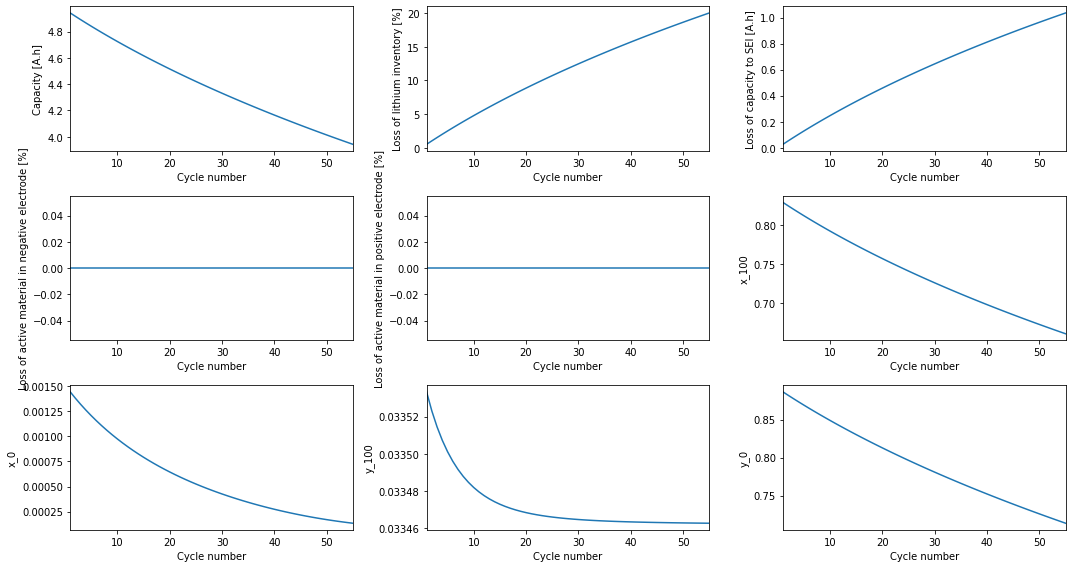

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [8]:
pybamm.plot_summary_variables(sol)

To suggest additional summary variables, open an issue!

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [9]:
# With integer
sol_int = sim.solve(save_at_cycles=5)
# With list
sol_list = sim.solve(save_at_cycles=[30,45,55])

2021-09-17 01:13:32,933 - [NOTICE] simulation.solve(809): Cycle 1/500 (36.016 ms elapsed) --------------------
2021-09-17 01:13:32,933 - [NOTICE] simulation.solve(843): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:32,975 - [NOTICE] simulation.solve(843): Cycle 1/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:33,012 - [NOTICE] simulation.solve(843): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:33,036 - [NOTICE] simulation.solve(843): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:33,186 - [NOTICE] simulation.solve(921): Capacity is now 3.944 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:33,186 - [NOTICE] simulation.solve(809): Cycle 2/500 (281.840 ms elapsed) --------------------
2021-09-17 01:13:33,186 - [NOTICE] simulation.solve(843): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:33,218 - [NOTICE] simulation.solve(843): Cycle 2/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:33,244 - [NO

2021-09-17 01:13:34,481 - [NOTICE] simulation.solve(843): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:34,516 - [NOTICE] simulation.solve(921): Capacity is now 3.784 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:34,517 - [NOTICE] simulation.solve(809): Cycle 14/500 (1.613 s elapsed) --------------------
2021-09-17 01:13:34,517 - [NOTICE] simulation.solve(843): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:34,542 - [NOTICE] simulation.solve(843): Cycle 14/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:34,566 - [NOTICE] simulation.solve(843): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:34,589 - [NOTICE] simulation.solve(843): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:34,625 - [NOTICE] simulation.solve(921): Capacity is now 3.772 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:34,625 - [NOTICE] simulation.solve(809): Cycle 15/500 (1.722 s elapsed) --------------------

2021-09-17 01:13:35,808 - [NOTICE] simulation.solve(843): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:35,844 - [NOTICE] simulation.solve(843): Cycle 26/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:35,868 - [NOTICE] simulation.solve(843): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:35,891 - [NOTICE] simulation.solve(843): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:35,924 - [NOTICE] simulation.solve(921): Capacity is now 3.626 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:35,925 - [NOTICE] simulation.solve(809): Cycle 27/500 (3.020 s elapsed) --------------------
2021-09-17 01:13:35,925 - [NOTICE] simulation.solve(843): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:35,949 - [NOTICE] simulation.solve(843): Cycle 27/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:35,962 - [NOTICE] simulation.solve(843): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:35,995 - [NOT

2021-09-17 01:13:37,143 - [NOTICE] simulation.solve(843): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:37,181 - [NOTICE] simulation.solve(921): Capacity is now 3.492 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:37,181 - [NOTICE] simulation.solve(809): Cycle 39/500 (4.279 s elapsed) --------------------
2021-09-17 01:13:37,181 - [NOTICE] simulation.solve(843): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:37,196 - [NOTICE] simulation.solve(843): Cycle 39/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:37,228 - [NOTICE] simulation.solve(843): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:37,243 - [NOTICE] simulation.solve(843): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:37,283 - [NOTICE] simulation.solve(921): Capacity is now 3.482 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:37,283 - [NOTICE] simulation.solve(809): Cycle 40/500 (4.381 s elapsed) --------------------

2021-09-17 01:13:38,439 - [NOTICE] simulation.solve(843): Cycle 51/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:38,465 - [NOTICE] simulation.solve(843): Cycle 51/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:38,489 - [NOTICE] simulation.solve(843): Cycle 51/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:38,508 - [NOTICE] simulation.solve(843): Cycle 51/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:38,545 - [NOTICE] simulation.solve(921): Capacity is now 3.358 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:38,546 - [NOTICE] simulation.solve(809): Cycle 52/500 (5.641 s elapsed) --------------------
2021-09-17 01:13:38,547 - [NOTICE] simulation.solve(843): Cycle 52/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:38,571 - [NOTICE] simulation.solve(843): Cycle 52/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:38,590 - [NOTICE] simulation.solve(843): Cycle 52/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:38,615 - [NOT

2021-09-17 01:13:39,791 - [NOTICE] simulation.solve(843): Cycle 63/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:39,828 - [NOTICE] simulation.solve(921): Capacity is now 3.243 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:39,828 - [NOTICE] simulation.solve(809): Cycle 64/500 (6.924 s elapsed) --------------------
2021-09-17 01:13:39,828 - [NOTICE] simulation.solve(843): Cycle 64/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:39,849 - [NOTICE] simulation.solve(843): Cycle 64/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:39,870 - [NOTICE] simulation.solve(843): Cycle 64/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:39,897 - [NOTICE] simulation.solve(843): Cycle 64/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:39,932 - [NOTICE] simulation.solve(921): Capacity is now 3.234 Ah (originally 3.944 Ah, will stop at 3.155 Ah)
2021-09-17 01:13:39,932 - [NOTICE] simulation.solve(809): Cycle 65/500 (7.030 s elapsed) --------------------

2021-09-17 01:13:41,448 - [NOTICE] simulation.solve(809): Cycle 3/500 (598.112 ms elapsed) --------------------
2021-09-17 01:13:41,448 - [NOTICE] simulation.solve(843): Cycle 3/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:41,472 - [NOTICE] simulation.solve(843): Cycle 3/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:41,494 - [NOTICE] simulation.solve(843): Cycle 3/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:41,502 - [NOTICE] simulation.solve(843): Cycle 3/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:41,551 - [NOTICE] simulation.solve(921): Capacity is now 3.137 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:41,551 - [NOTICE] simulation.solve(809): Cycle 4/500 (698.211 ms elapsed) --------------------
2021-09-17 01:13:41,551 - [NOTICE] simulation.solve(843): Cycle 4/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:41,572 - [NOTICE] simulation.solve(843): Cycle 4/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:41,594 - [N

2021-09-17 01:13:42,772 - [NOTICE] simulation.solve(843): Cycle 15/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:42,805 - [NOTICE] simulation.solve(921): Capacity is now 3.047 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:42,806 - [NOTICE] simulation.solve(809): Cycle 16/500 (1.951 s elapsed) --------------------
2021-09-17 01:13:42,807 - [NOTICE] simulation.solve(843): Cycle 16/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:42,831 - [NOTICE] simulation.solve(843): Cycle 16/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:42,864 - [NOTICE] simulation.solve(843): Cycle 16/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:42,875 - [NOTICE] simulation.solve(843): Cycle 16/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:42,916 - [NOTICE] simulation.solve(921): Capacity is now 3.041 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:42,916 - [NOTICE] simulation.solve(809): Cycle 17/500 (2.066 s elapsed) --------------------

2021-09-17 01:13:44,048 - [NOTICE] simulation.solve(843): Cycle 28/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:44,069 - [NOTICE] simulation.solve(843): Cycle 28/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:44,085 - [NOTICE] simulation.solve(843): Cycle 28/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:44,113 - [NOTICE] simulation.solve(843): Cycle 28/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:44,141 - [NOTICE] simulation.solve(921): Capacity is now 2.970 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:44,141 - [NOTICE] simulation.solve(809): Cycle 29/500 (3.291 s elapsed) --------------------
2021-09-17 01:13:44,141 - [NOTICE] simulation.solve(843): Cycle 29/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:44,168 - [NOTICE] simulation.solve(843): Cycle 29/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:44,192 - [NOTICE] simulation.solve(843): Cycle 29/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:44,211 - [NOT

2021-09-17 01:13:45,351 - [NOTICE] simulation.solve(843): Cycle 40/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:45,404 - [NOTICE] simulation.solve(921): Capacity is now 2.909 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:45,404 - [NOTICE] simulation.solve(809): Cycle 41/500 (4.549 s elapsed) --------------------
2021-09-17 01:13:45,405 - [NOTICE] simulation.solve(843): Cycle 41/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:45,430 - [NOTICE] simulation.solve(843): Cycle 41/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:45,458 - [NOTICE] simulation.solve(843): Cycle 41/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:45,476 - [NOTICE] simulation.solve(843): Cycle 41/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:45,516 - [NOTICE] simulation.solve(921): Capacity is now 2.904 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:45,517 - [NOTICE] simulation.solve(809): Cycle 42/500 (4.662 s elapsed) --------------------

2021-09-17 01:13:46,685 - [NOTICE] simulation.solve(843): Cycle 53/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:46,708 - [NOTICE] simulation.solve(843): Cycle 53/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:46,735 - [NOTICE] simulation.solve(843): Cycle 53/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:46,754 - [NOTICE] simulation.solve(843): Cycle 53/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:46,791 - [NOTICE] simulation.solve(921): Capacity is now 2.842 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:46,792 - [NOTICE] simulation.solve(809): Cycle 54/500 (5.937 s elapsed) --------------------
2021-09-17 01:13:46,793 - [NOTICE] simulation.solve(843): Cycle 54/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:46,816 - [NOTICE] simulation.solve(843): Cycle 54/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:46,845 - [NOTICE] simulation.solve(843): Cycle 54/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:46,865 - [NOT

2021-09-17 01:13:48,015 - [NOTICE] simulation.solve(843): Cycle 65/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:48,054 - [NOTICE] simulation.solve(921): Capacity is now 2.773 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:48,055 - [NOTICE] simulation.solve(809): Cycle 66/500 (7.199 s elapsed) --------------------
2021-09-17 01:13:48,055 - [NOTICE] simulation.solve(843): Cycle 66/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:48,066 - [NOTICE] simulation.solve(843): Cycle 66/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:48,086 - [NOTICE] simulation.solve(843): Cycle 66/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:48,103 - [NOTICE] simulation.solve(843): Cycle 66/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:48,161 - [NOTICE] simulation.solve(921): Capacity is now 2.767 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:48,163 - [NOTICE] simulation.solve(809): Cycle 67/500 (7.307 s elapsed) --------------------

2021-09-17 01:13:49,308 - [NOTICE] simulation.solve(843): Cycle 78/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:49,338 - [NOTICE] simulation.solve(843): Cycle 78/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:49,363 - [NOTICE] simulation.solve(843): Cycle 78/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:49,381 - [NOTICE] simulation.solve(843): Cycle 78/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:49,416 - [NOTICE] simulation.solve(921): Capacity is now 2.694 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:49,416 - [NOTICE] simulation.solve(809): Cycle 79/500 (8.563 s elapsed) --------------------
2021-09-17 01:13:49,416 - [NOTICE] simulation.solve(843): Cycle 79/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:49,441 - [NOTICE] simulation.solve(843): Cycle 79/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:49,465 - [NOTICE] simulation.solve(843): Cycle 79/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:49,484 - [NOT

2021-09-17 01:13:50,597 - [NOTICE] simulation.solve(843): Cycle 90/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:50,626 - [NOTICE] simulation.solve(921): Capacity is now 2.620 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:50,626 - [NOTICE] simulation.solve(809): Cycle 91/500 (9.779 s elapsed) --------------------
2021-09-17 01:13:50,626 - [NOTICE] simulation.solve(843): Cycle 91/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:50,656 - [NOTICE] simulation.solve(843): Cycle 91/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:50,682 - [NOTICE] simulation.solve(843): Cycle 91/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:50,698 - [NOTICE] simulation.solve(843): Cycle 91/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:50,726 - [NOTICE] simulation.solve(921): Capacity is now 2.614 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:50,726 - [NOTICE] simulation.solve(809): Cycle 92/500 (9.882 s elapsed) --------------------

2021-09-17 01:13:51,897 - [NOTICE] simulation.solve(843): Cycle 103/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:51,927 - [NOTICE] simulation.solve(843): Cycle 103/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:51,950 - [NOTICE] simulation.solve(843): Cycle 103/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:51,970 - [NOTICE] simulation.solve(843): Cycle 103/500, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:52,001 - [NOTICE] simulation.solve(921): Capacity is now 2.542 Ah (originally 3.154 Ah, will stop at 2.523 Ah)
2021-09-17 01:13:52,001 - [NOTICE] simulation.solve(809): Cycle 104/500 (11.157 s elapsed) --------------------
2021-09-17 01:13:52,001 - [NOTICE] simulation.solve(843): Cycle 104/500, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:52,034 - [NOTICE] simulation.solve(843): Cycle 104/500, step 2/4: Rest for 1 hour
2021-09-17 01:13:52,058 - [NOTICE] simulation.solve(843): Cycle 104/500, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:52,0

In [10]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [12]:
sol_list.cycles[44].plot(["Current [A]","Terminal voltage [V]"])

interactive(children=(FloatSlider(value=100.84278906802614, description='t', max=103.08965241980624, min=100.8…

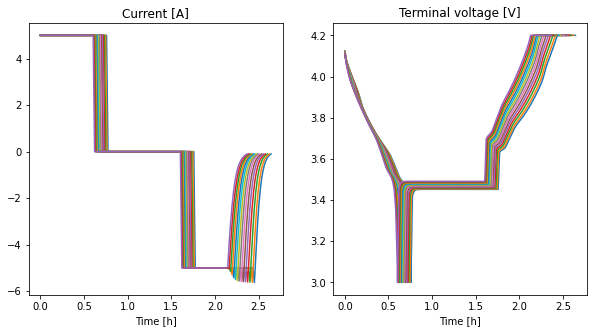

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Terminal voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Terminal voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

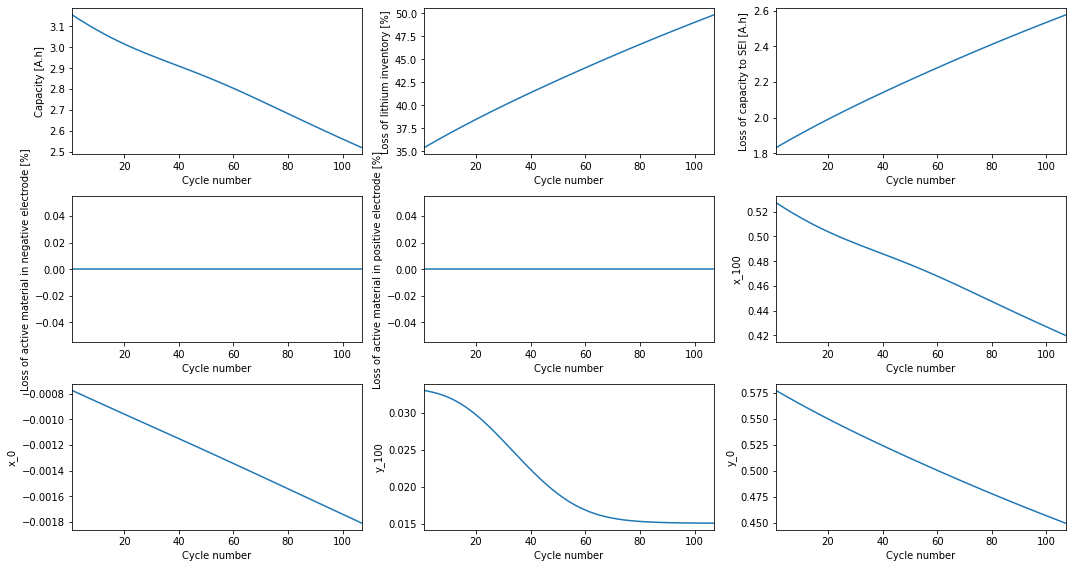

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [14]:
pybamm.plot_summary_variables(sol_list)

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [15]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 10,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-09-17 01:13:55,885 - [NOTICE] simulation.solve(809): Cycle 1/10 (30.080 ms elapsed) --------------------
2021-09-17 01:13:55,885 - [NOTICE] simulation.solve(843): Cycle 1/10, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:55,941 - [NOTICE] simulation.solve(843): Cycle 1/10, step 2/4: Rest for 1 hour
2021-09-17 01:13:55,992 - [NOTICE] simulation.solve(843): Cycle 1/10, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:56,032 - [NOTICE] simulation.solve(843): Cycle 1/10, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:56,255 - [NOTICE] simulation.solve(921): Capacity is now 4.943 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:56,255 - [NOTICE] simulation.solve(809): Cycle 2/10 (395.311 ms elapsed) --------------------
2021-09-17 01:13:56,255 - [NOTICE] simulation.solve(843): Cycle 2/10, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:56,291 - [NOTICE] simulation.solve(843): Cycle 2/10, step 2/4: Rest for 1 hour
2021-09-17 01:13:56,317 - [NOTICE] si

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [16]:
sol2 = sim.solve(starting_solution=sol)

2021-09-17 01:13:57,398 - [NOTICE] simulation.solve(809): Cycle 11/20 (38.041 ms elapsed) --------------------
2021-09-17 01:13:57,399 - [NOTICE] simulation.solve(843): Cycle 11/20, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:57,426 - [NOTICE] simulation.solve(843): Cycle 11/20, step 2/4: Rest for 1 hour
2021-09-17 01:13:57,450 - [NOTICE] simulation.solve(843): Cycle 11/20, step 3/4: Charge at 1C until 4.2V
2021-09-17 01:13:57,483 - [NOTICE] simulation.solve(843): Cycle 11/20, step 4/4: Hold at 4.2V until C/50
2021-09-17 01:13:57,626 - [NOTICE] simulation.solve(921): Capacity is now 4.703 Ah (originally 4.943 Ah, will stop at 3.954 Ah)
2021-09-17 01:13:57,626 - [NOTICE] simulation.solve(809): Cycle 12/20 (278.438 ms elapsed) --------------------
2021-09-17 01:13:57,626 - [NOTICE] simulation.solve(843): Cycle 12/20, step 1/4: Discharge at 1C until 3.0V
2021-09-17 01:13:57,662 - [NOTICE] simulation.solve(843): Cycle 12/20, step 2/4: Rest for 1 hour
2021-09-17 01:13:57,693 - [NO

We have now simulated 20 cycles

In [17]:
len(sol2.cycles)

20

## References

The relevant papers for this notebook are:

In [18]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Peyman Mohtat, Suhak Lee, Jason B Siegel, and Anna G Stefanopoulou. Towards better estimability of electrode-specific state of health: decoding the cell expansion. Journal of Power Sources, 427:101–111, 201